In [28]:
!pip install praw
import praw
import pandas as pd
import re
import nltk
from textblob import TextBlob
from geopy.geocoders import Nominatim
import folium

# Download stopwords
nltk.download("stopwords")
from nltk.corpus import stopwords

# Define stopwords
STOPWORDS = set(stopwords.words("english"))

# 🔹 Configure Reddit API (Replace with your own credentials)
# 🔹 Configure Reddit API (Replace with your own credentials)
reddit = praw.Reddit(
    client_id="jTCsKDZ_JZIPWlDGbbabzQ",
    client_secret="_JzHwbW1-74ymbGYPtA8m5kiLrHQbQ",
    user_agent="Hefty_Ad854"
)

# 🔹 Keywords for filtering
KEYWORDS = [
    "depressed", "addiction help", "overwhelmed", "suicidal",
    "mental health", "anxiety", "panic attack", "self harm",
    "substance abuse", "lonely", "despair", "isolation",
    "hopeless", "grief", "distress"
]
import re

# Enhanced Location Extraction Function
def extract_location_from_post(post):
    # Check for location in author flair
    if hasattr(post, 'author_flair_text') and post.author_flair_text:
        return post.author_flair_text

    # Search for location in title or text (common city/state patterns)
    location_patterns = r'(in|at|near)\s([A-Za-z\s]+)'
    location_match = re.search(location_patterns, post.title + " " + post.selftext, re.IGNORECASE)
    if location_match:
        return location_match.group(2).strip()

    # Extract potential location from URL (e.g., /r/LosAngeles/)
    if 'reddit.com/r/' in post.url:
        url_parts = post.url.split('/')
        for part in url_parts:
            if part.lower() in ['losangeles', 'newyork', 'chicago']:  # Add relevant city names
                return part.capitalize()

    return None
# 🔹 Data Extraction Function
def extract_reddit_data(subreddit_name, limit=500):
    posts = []
    subreddit = reddit.subreddit(subreddit_name)
    for post in subreddit.new(limit=limit):
        if any(keyword in post.title.lower() or keyword in post.selftext.lower() for keyword in KEYWORDS):
            posts.append({
                "Post ID": post.id,
                "Timestamp": post.created_utc,
                "Content": post.selftext,
                "Likes": post.score,
                "Comments": post.num_comments,
                "Shares": post.num_crossposts,
                "Location":  extract_location_from_post(post)

            })
    return pd.DataFrame(posts)

# 🔹 Text Cleaning Function
def clean_text(text):
    text = re.sub(r"http\S+|www\.\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)          # Remove special characters
    text = " ".join(word for word in text.split() if word.lower() not in STOPWORDS)  # Remove stopwords
    return text.strip().lower()

# 🔹 Main Script
df = extract_reddit_data("depression", limit=500)
df["Cleaned Content"] = df["Content"].apply(clean_text)

# Display top 10 values in a formatted table
print("\n🟩 Top 10 Reddit Posts (Cleaned Data):\n")
print("{:<5} | {:<70} | {:<8} | {:<8}".format("S.No", "Cleaned Content", "Likes", "Comments"))
print("-" * 100)

for idx, row in df.head(10).iterrows():
    print("{:<5} | {:<70} | {:<8} | {:<8}".format(
        idx + 1,
        row["Cleaned Content"][:65] + "..." if len(row["Cleaned Content"]) > 65 else row["Cleaned Content"],
        row["Likes"],
        row["Comments"]
    ))


# 🔹 Save as CSV
df.to_csv("cleaned_reddit_data.csv", index=False)
print("\n✅ Data extraction and cleaning completed successfully!")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info


🟩 Top 10 Reddit Posts (Cleaned Data):

S.No  | Cleaned Content                                                        | Likes    | Comments
----------------------------------------------------------------------------------------------------
1     | feel severely depressed since woke everything seems meaningless p...   | 1        | 0       
2     | im going say age idk age requirement thought years get girlfriend...   | 2        | 3       
3     | mom hates everyone hates never anything right want feel something...   | 4        | 3       
4     | really need get stuff chest thank advice reading female live mum ...   | 1        | 0       
5     | im yo whos struggled small suicidal thoughts trying find safe pla...   | 2        | 1       
6     | social life live lonely existence dislike looking often feel like...   | 3        | 3       
7     | turn year realisation last years changed little may aswell coma w...   | 1        | 1       
8     | postpartum depression patient partner trigg

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


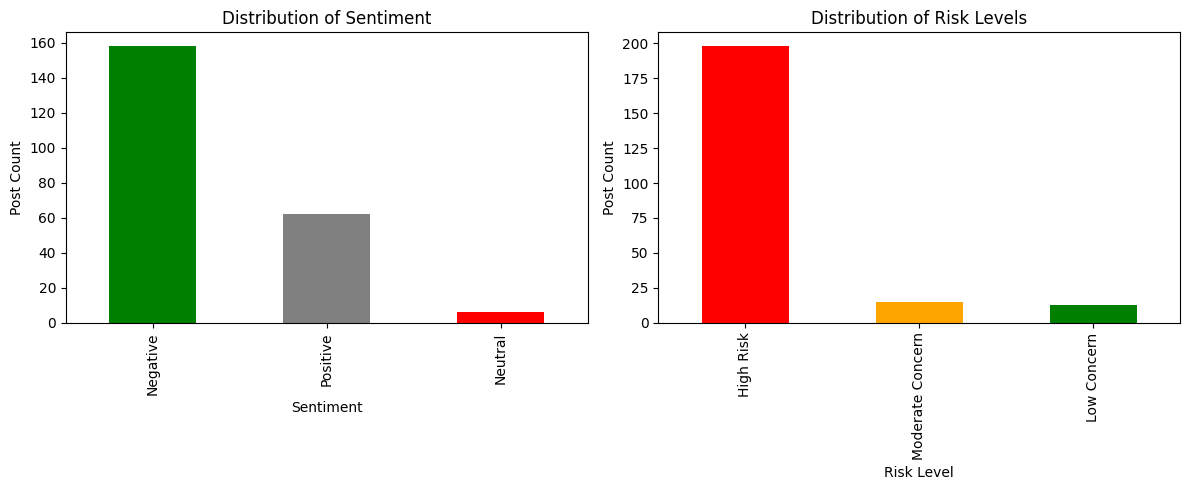

In [16]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import nltk
import re

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Load cleaned data
df = pd.read_csv("cleaned_reddit_data.csv")

# Sentiment Classification Function
def classify_sentiment(text):
    score = analyzer.polarity_scores(text)
    if score['compound'] >= 0.05:
        return "Positive"
    elif score['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['Cleaned Content'].apply(classify_sentiment)

# Crisis Keywords for Risk Level Classification
high_risk_terms = [
    "depressed", "end", "struggle", "anxiety","depression","suicide","depressed", "end", "struggle", "anxiety", "depression", "suicide",
    "hopeless", "worthless", "no way out", "can't go on", "giving up",
    "ending it", "goodbye", "life is meaningless", "self harm", "hurting myself"
]
moderate_risk_terms = [
    "lost", "overwhelmed", "struggling", "help", "feeling lost", "overwhelmed", "struggling", "need help",
    "empty", "not okay", "tired",
    "burned out", "drained", "can't focus", "hard","Frustrated","Confused"
]

# Risk Level Classification Function
def classify_risk_level(text):
    text = text.lower()
    if any(term in text for term in high_risk_terms):
        return "High Risk"
    elif any(term in text for term in moderate_risk_terms):
        return "Moderate Concern"
    else:
        return "Low Concern"

df['Risk Level'] = df['Cleaned Content'].apply(classify_risk_level)

# Display top 10 classified values
print(df[['Cleaned Content', 'Sentiment', 'Risk Level']].head(10).to_string(index=False))

# Visualization of Sentiment and Risk Level Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df['Sentiment'].value_counts().plot(kind='bar', color=['green', 'grey', 'red'])
plt.title("Distribution of Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Post Count")

plt.subplot(1, 2, 2)
df['Risk Level'].value_counts().plot(kind='bar', color=['red', 'orange', 'green'])
plt.title("Distribution of Risk Levels")
plt.xlabel("Risk Level")
plt.ylabel("Post Count")

plt.tight_layout()
plt.show()


In [20]:
print(df.columns)


Index(['Post ID', 'Timestamp', 'Content', 'Likes', 'Comments', 'Shares',
       'Cleaned Content', 'Sentiment', 'Risk Level'],
      dtype='object')


In [29]:
# Geolocation Mapping (Sample Data for Visualization)
geolocator = Nominatim(user_agent="geoapi", timeout=5)

def get_location_with_retry(location_name, retries=3):
    for attempt in range(retries):
        try:
            return geolocator.geocode(location_name)
        except GeocoderTimedOut:
            print(f"Timeout for {location_name}, retrying ({attempt + 1}/{retries})...")
            time.sleep(2)
    return None

map_data = df['Location'].value_counts().reset_index()
map_data.columns = ['Location', 'Count']

m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

for idx, row in map_data.iterrows():
    location = get_location_with_retry(row['Location'])
    if location:
        folium.CircleMarker(
            location=[location.latitude, location.longitude],
            radius=row['Count'] / 5,
            color='blue',
            fill=True,
            fill_color='blue'
        ).add_to(m)

m.save("crisis_heatmap.html")
print("Heatmap created and saved as 'crisis_heatmap.html'")


Heatmap created and saved as 'crisis_heatmap.html'
